In [1]:
from floorplan import Box, Net, FloorPlan

import cvxpy as cp
from cvxpy import Variable, Constant, Minimize, Problem
import numpy as np
import placedb
import pylab
import math
import joblib

%load_ext autoreload
%autoreload 2

In [2]:
numCores = joblib.cpu_count()

In [3]:
design = "xerox"
input_dir = "input_pin_aware/mcnc/"
blocksfile = "{}{}.block".format(input_dir,design)
netsfile = "{}{}.nets".format(input_dir,design) 
#plfile = "{}{}.pl".format(input_dir,design)
plfile = "tmp/14.out.pl"

In [4]:
pdb = placedb.PlaceDB()
p = placedb.Params()

In [5]:
pdb.read_block(p,blocksfile)
pdb.read_nets_mcnc(p,netsfile)
pdb.read_pl(p,plfile)
pdb.initialize(p)

In [11]:
n = pdb.num_movable_nodes
nn = pdb.num_terminals

nets = []
for i, net in enumerate(pdb.net2pin_map):
    nodes = [pdb.pin2node_map[i] for i in net]
    if len(nodes) <= 1: continue
    nets.append(Net(nodes, i))
    
boxes = []
for i in range(n):
    boxes.append(Box(pdb.node_size_x[i], pdb.node_size_y[i], pdb.node_x[i], pdb.node_y[i], 1-int(pdb.node_orient[i]), idx=i, 
                     r=False, pl=False))

placeable_area = (pdb.xh, pdb.yh)
pin_placeable_area = [-1e8, -1e8]
# pins
for i in range(nn):
    if pdb.node_x[i+n] >= pin_placeable_area[0]:
        pin_placeable_area[0] =  pdb.node_x[i+n]
    
    if pdb.node_y[i+n] >= pin_placeable_area[1]:
        pin_placeable_area[1] =  pdb.node_y[i+n]
        
    boxes.append(Box(0, 0, pdb.node_x[i+n], pdb.node_y[i+n], idx=i+n, pl=False, r=False, terminal=True))    

xh = max(pin_placeable_area[0], pdb.xh)
yh = max(pin_placeable_area[1], pdb.yh)
    
fp = FloorPlan(boxes, nets, xh, yh, max_seconds=3600, num_cores=numCores-1, name=design)

In [12]:
xh, yh

(5336.0, 6412.0)

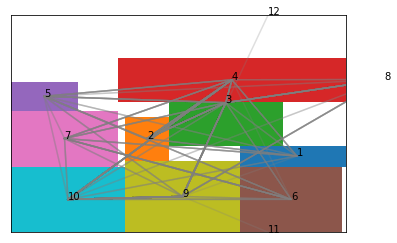

CPU times: user 3.53 s, sys: 28 ms, total: 3.56 s
Wall time: 3.55 s


In [13]:
%%time
p, c = fp.layout()
fp.show()
violations = fp.verify_constraints(c)
assert np.all(violations <= 1e-5)

In [14]:
print(p)

585077.5
